In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

from gensim.models import Word2Vec
from scapy.all import PcapReader
from sklearn.feature_selection import f_classif, SelectKBest, RFE
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import shuffle, resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc,
    precision_recall_curve,
)

from read_pcaps import pcap_to_dataframe

2024-05-28 18:02:54.367374: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-28 18:02:54.434667: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 18:02:54.434721: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 18:02:54.436525: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-28 18:02:54.446870: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-28 18:02:56.211331: W tensorflow/compiler/tf2tensorrt/utils/py_utils.

In [2]:
# define a variable that allows you to read prior saved pkl files
READ_FROM_PKL = True

In [3]:
if READ_FROM_PKL:
    mirai_df = pd.read_pickle("../data/blog_eda/mirai.pkl")
    benign_df = pd.read_pickle("../data/blog_eda/benign.pkl")
else:
    pcap_reader_mirai = PcapReader("../data/blog_eda/mirai.pcap")
    pcap_reader_benign = PcapReader("../data/blog_eda/benign.pcapng")
    mirai_df = pcap_to_dataframe(pcap_reader_mirai)
    benign_df = pcap_to_dataframe(pcap_reader_benign)

In [4]:
# read features saved, add new ones
if READ_FROM_PKL:
    mirai_features_df = pd.read_pickle("../data/blog_fe/mirai_features.pkl")
    benign_features_df = pd.read_pickle("../data/blog_fe/benign_features.pkl")
else:
    print(
        "Error! Feature pkl not saved. Please run blog_fe_2.ipynb, blog_fe_3.ipynb, blog_fe_4.ipynb or download from here: https://drive.google.com/drive/folders/1dBQhbQtIk_fbbb80G5pSVV3hbWYJY7fv?usp=sharing"
    )

In [5]:
# drop rows with None
mirai_df = mirai_df.dropna()
benign_df = benign_df.dropna()

# Add labels

In [6]:
# add labels, 0 for benign, 1 for malicious
mirai_features_df["Label"] = 1
benign_features_df["Label"] = 0

In [7]:
concatenated_df = pd.concat([mirai_features_df, benign_features_df], ignore_index=True)

In [8]:
shuffled_df = shuffle(concatenated_df, random_state=42)

In [9]:
# make sure that all features are numeric, otherwise feature selection will not work
shuffled_df.columns

Index(['Timestamp', 'Source Port', 'Destination Port', 'Packet Length',
       'Protocol', 'incoming_traffic', 'outgoing_traffic', 'traffic_ratio',
       'cumulative_length', 'interarrival', 'log_interarrival',
       'Numeric Source IP', 'Numeric Destination IP', 'payload_proto_encoded',
       'ICMP', 'TCP', 'UDP', 'Telnet', 'IPv6_encapsulation', 'GRE', 'ESP',
       'AH', 'DNS', 'ICMPv6', 'OSPF', 'SCTP', 'UDPLite', 'NETBIOS-NS',
       'NETBIOS-DGM', 'NETBIOS-SSN', 'IMAP', 'SNMP', 'SNMP_trap', 'HTTPS',
       'Syslog', 'LDAPS', 'FTPS', 'IMAPS', 'POP3S', 'SOCKS_proxy',
       'length_risk', 'dst_port_freq_encoded', 'payload_embedding', 'Label'],
      dtype='object')

In [10]:
shuffled_df = shuffled_df.drop("payload_embedding", axis=1)
shuffled_df_values = shuffled_df.values.astype(np.float64)

# Find rows with infinite values
inf_rows = np.isinf(shuffled_df_values).any(axis=1)

# Remove rows with infinite values
shuffled_df = shuffled_df[~inf_rows]

In [11]:
# Find rows with infinite values
inf_rows = shuffled_df.index[np.isinf(shuffled_df).any(1)]

# Remove rows with infinite values
shuffled_df = shuffled_df.drop(inf_rows)

# Display the DataFrame after removing rows with infinite values
print("\nDataFrame after removing rows with infinite values:")
print(shuffled_df)


DataFrame after removing rows with infinite values:
           Timestamp  Source Port  Destination Port  Packet Length  Protocol  \
104819  1.540452e+09      33489.0              53.0           41.0      17.0   
171876           NaN          NaN               NaN            NaN       NaN   
50181   1.540449e+09       4259.0              53.0           38.0      17.0   
144342  1.540453e+09      21897.0              23.0           26.0       6.0   
201802           NaN          NaN               NaN            NaN       NaN   
...              ...          ...               ...            ...       ...   
119879  1.540452e+09         23.0           21897.0           26.0       6.0   
103694  1.540452e+09       2148.0              53.0           50.0      17.0   
131932  1.540453e+09      59081.0              53.0           48.0      17.0   
146867  1.540453e+09      21897.0              23.0           26.0       6.0   
121958  1.540452e+09      50861.0           10240.0           48.0 

/tmp/ipykernel_1187537/458818108.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  inf_rows = shuffled_df.index[np.isinf(shuffled_df).any(1)]


In [12]:
shuffled_df = shuffled_df.dropna()

# Downsample

In [13]:
# Separate majority and minority classes
majority_class = shuffled_df[shuffled_df["Label"] == 1]
minority_class = shuffled_df[shuffled_df["Label"] == 0]

# Downsample majority class
downsampled_majority = resample(
    majority_class,
    replace=False,  # sample without replacement
    n_samples=len(minority_class),  # to match minority class
    random_state=42,
)  # reproducible results

# Combine minority class with downsampled majority class
downsampled_data = pd.concat([downsampled_majority, minority_class])

# Shuffle the data
downsampled_data = downsampled_data.sample(frac=1, random_state=42)

# Split data
- Train
- Test

In [14]:
# X should contain your feature columns, and y should contain the labels (0 or 1)
X = downsampled_data.drop(columns=["Label"], axis=1)
y = downsampled_data["Label"]


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Random Forest Classifier

In [15]:
# Train a classifier using the selected features
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [16]:
# Calculate metrics
y_true = downsampled_data["Label"]  # True labels
y_pred = clf.predict(downsampled_data.drop("Label", axis=1))  # Predicted labels

# Decision Tree

In [17]:
# Train a classifier using the selected features
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [18]:
# Calculate metrics
y_true = downsampled_data["Label"]  # True labels
y_pred = clf.predict(downsampled_data.drop("Label", axis=1))  # Predicted labels

# Evaluation

## Confusion Matrix

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(model, X, y):
    # Initialize an empty confusion matrix
    cm = np.zeros((len(np.unique(y)), len(np.unique(y))), dtype=int)

    # Perform k-fold cross-validation and accumulate the confusion matrix
    predictions = cross_val_predict(model, X, y, cv=5)  # Change cv value as needed
    cm += confusion_matrix(y, predictions)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

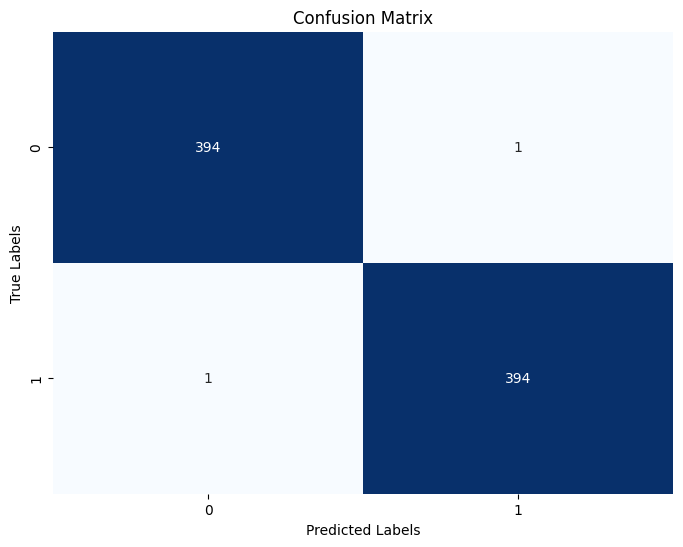

In [20]:
plot_confusion_matrix(dtree, X, y)

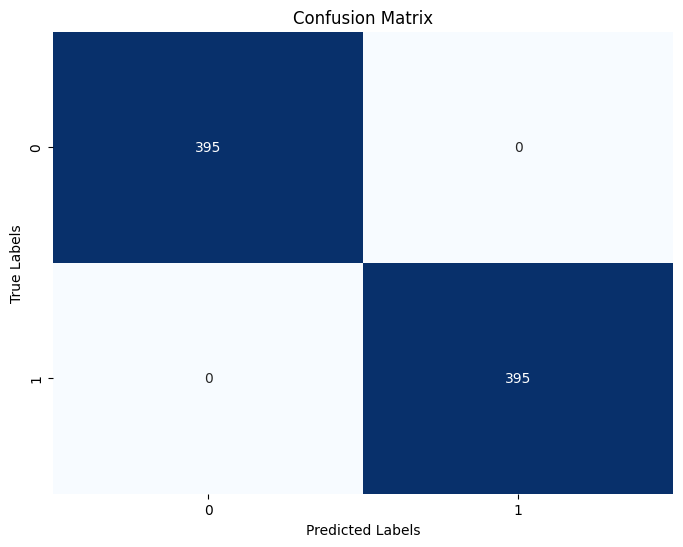

In [21]:
plot_confusion_matrix(clf, X, y)

## Accuracy, Precision, Recall, F-1

In [22]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, precision, recall, f1

In [23]:
dt_accuracy, dt_precision, dt_recall, dt_f1 = evaluate_model(
    dtree, X_test, y_test
)
print("Accuracy:", dt_accuracy)
print("Precision:", dt_precision)
print("Recall:", dt_recall)
print("F1 Score:", dt_f1)

Accuracy: 0.9936708860759493
Precision: 0.9886363636363636
Recall: 1.0
F1 Score: 0.9942857142857142


In [24]:
rf_accuracy, rf_precision, rf_recall, rf_f1 = evaluate_model(clf, X_test, y_test)
print("Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1 Score:", rf_f1)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


## ROC Curve and AUC

In [25]:
def plot_roc_curve(model, X, y, n_folds=5):
    # Initialize variables to store false positive rate and true positive rate for each fold
    mean_fpr = np.linspace(0, 1, 100)
    tpr_sum = 0

    X = X.values
    y = y.values

    # Create k-fold cross-validation iterator
    cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

    plt.figure(figsize=(8, 6))

    # iterate to train model and get ROC metric
    for train, test in cv.split(X, y):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]

        model.fit(X_train, y_train)
        y_prob = model.predict_proba(X_test)[:, 1]

        fpr, tpr, _ = roc_curve(y_test, y_prob)
        tpr_sum += np.interp(mean_fpr, fpr, tpr)
        plt.plot(fpr, tpr, lw=1, alpha=0.3)

    mean_tpr = tpr_sum / n_folds
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Random Chance")
    plt.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        lw=2,
        label="Mean ROC (AUC = {:.2f})".format(auc(mean_fpr, mean_tpr)),
    )

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.show()

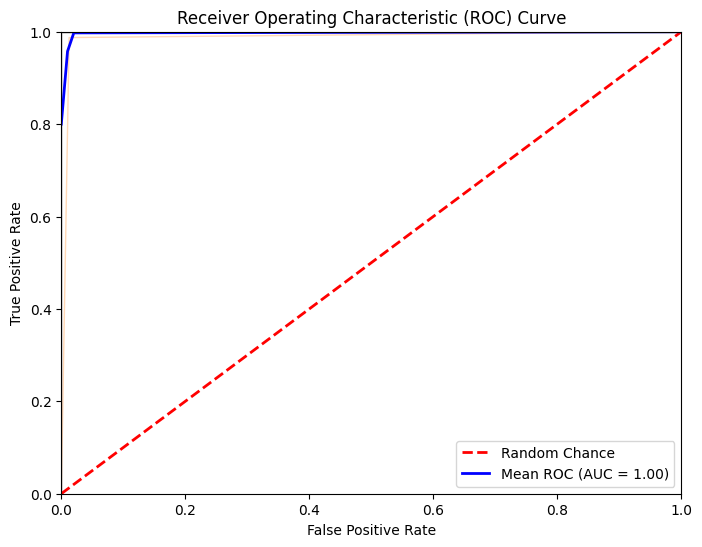

In [26]:
plot_roc_curve(dtree, X, y)

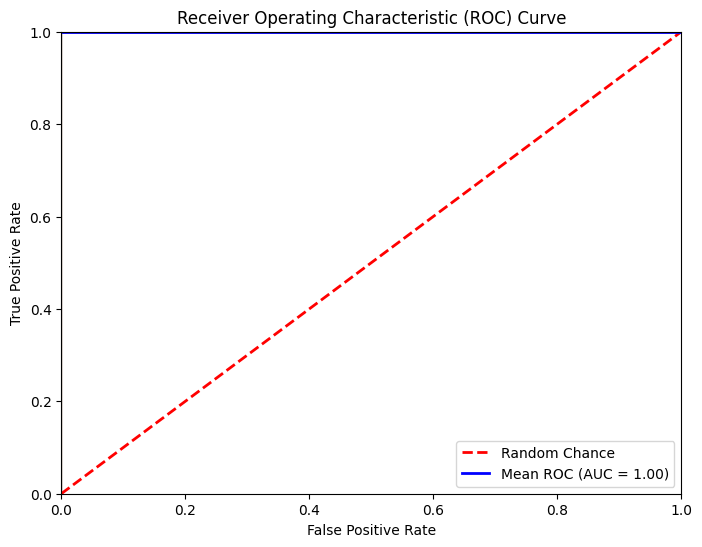

In [27]:
plot_roc_curve(clf, X, y)

In [28]:
# visualization no worky
# import dtreeviz
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.model_selection import train_test_split

# # Assuming df is your DataFrame with features and labels
# # Split the data into features and labels
# X = shuffled_df.drop("Label", axis=1)
# y = shuffled_df["Label"]

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )

# # Instantiate a decision tree classifier
# model = DecisionTreeClassifier()

# # Fit the model on the training data
# model.fit(X_train, y_train)

# # Visualize the decision tree
# viz_model = dtreeviz.model(
#     model,
#     X_train,
#     y_train,
#     target_name="Label",
#     feature_names=list(shuffled_df.columns[:-1]),  # Assuming the last column is the label column
#     class_names=["benign", "malicious"],
# )  # Specify class names if applicable

# # Display the visualization
# v = viz_model.view()  # render as SVG into internal object
# v.show()  # pop up window
# v.save("/tmp/mirai.svg")  # optionally save as svg